In [1]:
import numpy as np
import pandas as pd
import h5py
from fitsio import FITS
from astropy.table import Table, setdiff, vstack, join_skycoord, join
from astropy.coordinates import SkyCoord
import re
from glob import glob


import matplotlib.pyplot as plt
plt.style.use('MNRAS.mplstyle')

h = 0.7

filepath = r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/"

file_path = r"/bsuscratch/shuleicao/Cardinalv3/"

## load the redmapper clusters and members

In [2]:
# [q for q in  redmapper.list_all_native_quantities() if 'mag' in q]

In [3]:
redmapper_file_cl = FITS(file_path+"redmapper_v4_v8_v51_y6_v7/run/Cardinal-3Y6a_v2.0_run_run_redmapper_v0.8.1_lgt20_vl02_catalog.fit", mode=0)
redmapper_cl = Table(redmapper_file_cl[1].read())
print(len(redmapper_cl))

redmapper_file_me = FITS(file_path+"redmapper_v4_v8_v51_y6_v7/run/Cardinal-3Y6a_v2.0_run_run_redmapper_v0.8.1_lgt20_vl02_catalog_members.fit", mode=0)
redmapper_me = Table(redmapper_file_me[1].read())
print(len(redmapper_me))
# redmapper[:5]

15755
1043744


In [4]:
sum(redmapper_cl['lambda']<20), redmapper_cl['z'].min(), redmapper_cl['z'].max()

(0, 0.10528861, 0.94225204)

In [5]:
redmapper_cl = redmapper_cl[(redmapper_cl['z']>=0.2) & (redmapper_cl['z']<=0.65)]
print(len(redmapper_cl))

8255


In [7]:
yyyy = redmapper_me[(redmapper_me['p']>=0.5) & (redmapper_me['z']>=0.2) & (redmapper_me['z']<=1)]
ggg = np.array([item[0] for item in np.array(yyyy['mag'])])
rrr = np.array([item[1] for item in np.array(yyyy['mag'])])
iii = np.array([item[2] for item in np.array(yyyy['mag'])])
zzz = np.array([item[3] for item in np.array(yyyy['mag'])])

print((ggg).min(), (ggg).max())
print((rrr).min(), (rrr).max())
print((iii).min(), (iii).max())
print((zzz).min(), (zzz).max())

17.706347 28.71363
16.292122 25.211279
15.820626 24.041954
15.483568 23.13444


In [8]:
redmapper_cl_f = redmapper_cl[(redmapper_cl['z']>=0.2)]

zranges = [(0.2,0.35), (0.35, 0.5), (0.5, 0.65), (0.65, 0.8), (0.8,0.95)] #, 
lamranges = [(20,30), (30,45), (45,60), (60,500)]
zlabels = ['(0.2,0.35]', '(0.35, 0.5]', '(0.5, 0.65]', '(0.65, 0.8]', '(0.8,0.95]'] #, '(0.8,0.95]'
lamlabels = ['(20,30]', '(30,45]', '(45,60]', '(60,500]']
redmapper_cl_f['redshift_range'] = pd.cut(redmapper_cl_f['z'], bins=[r[0] for r in zranges] + [zranges[-1][-1]], labels=zlabels)
redmapper_cl_f['lambda_range'] = pd.cut(redmapper_cl_f['lambda'], bins=[r[0] for r in lamranges] + [lamranges[-1][-1]], labels=lamlabels)

grouped = redmapper_cl_f.group_by(['redshift_range', 'lambda_range'])
cluster_counts = grouped.groups.aggregate(len)
cluster_counts['mem_match_id', 'redshift_range', 'lambda_range']

mem_match_id,redshift_range,lambda_range
int64,object,object
492,"(0.2,0.35]","(20,30]"
124,"(0.2,0.35]","(30,45]"
27,"(0.2,0.35]","(45,60]"
43,"(0.2,0.35]","(60,500]"
2425,"(0.35, 0.5]","(20,30]"
709,"(0.35, 0.5]","(30,45]"
174,"(0.35, 0.5]","(45,60]"
148,"(0.35, 0.5]","(60,500]"
3142,"(0.5, 0.65]","(20,30]"


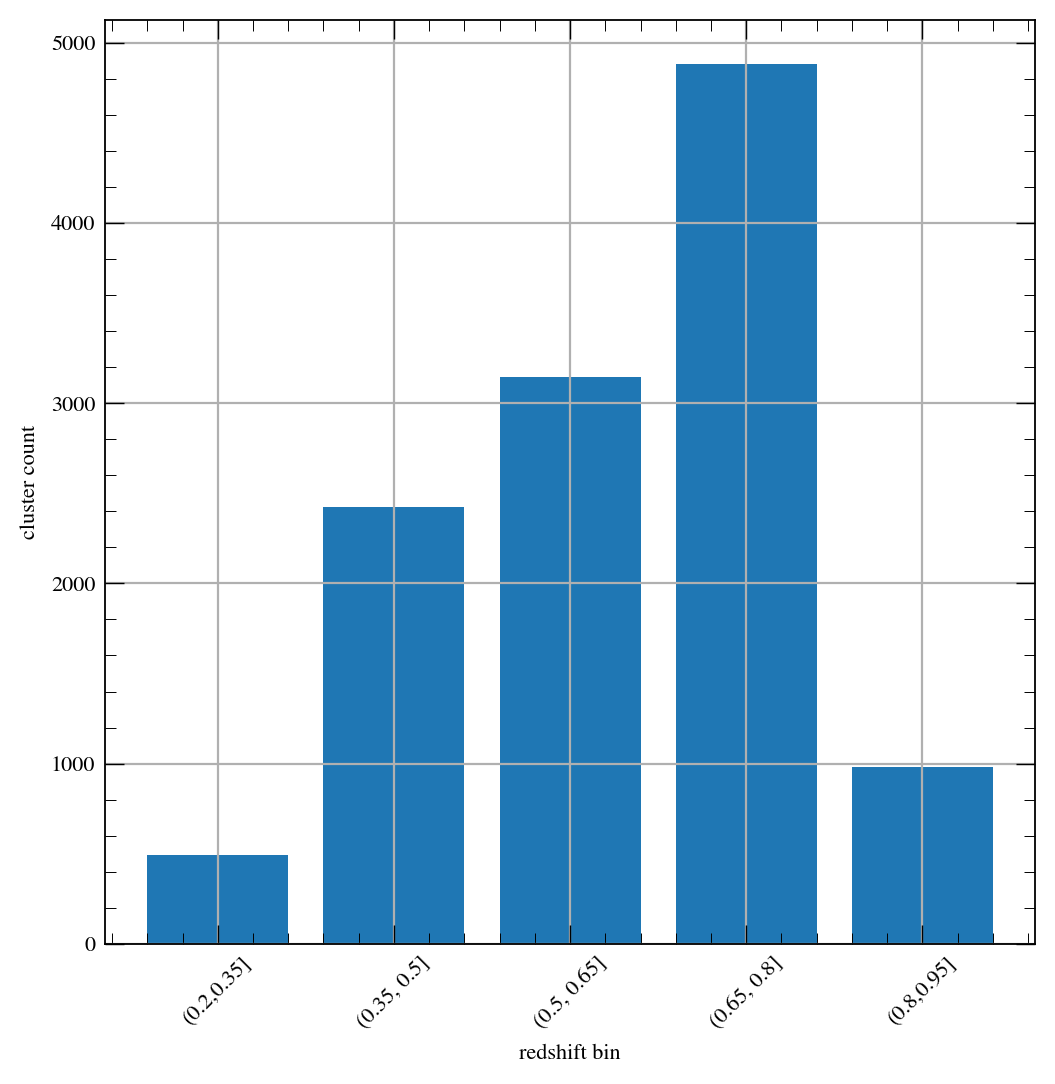

In [7]:
plt.bar(cluster_counts['redshift_range'], cluster_counts['mem_match_id'])
plt.ylabel('cluster count')
plt.xlabel('redshift bin')
plt.xticks(rotation=45)
plt.show()

In [8]:
(cluster_counts['mem_match_id']).sum(), len(redmapper_cl), (redmapper_cl['z']<0.2).sum(), (redmapper_cl['z']>0.95).sum()

(15702, 15755, 53, 0)

In [9]:
redmapper_cl.columns

<TableColumns names=('mem_match_id','ra','dec','z','refmag','refmag_err','lambda','lambda_e','z_lambda','z_lambda_e','cg_spec_z','z_spec_init','z_init','r_lambda','r_mask','scaleval','maskfrac','zred','zred_e','zred_chisq','chisq','z_lambda_niter','ebv_mean','lnlamlike','lncglike','lnlike','ra_orig','dec_orig','w','dlambda_dz','dlambda_dz2','dlambdavar_dz','dlambdavar_dz2','z_lambda_raw','z_lambda_e_raw','bkg_local','lim_exptime','lim_limmag','lim_limmag_hard','lambda_c','lambda_ce','ncent_good','maskgal_index','mag','mag_err','pzbins','pz','ra_cent','dec_cent','id_cent','lambda_cent','zlambda_cent','p_cen','q_cen','p_fg','q_miss','p_sat','p_c')>

In [10]:
print(len(redmapper_me))
redmapper_me.columns

1043744


<TableColumns names=('mem_match_id','id','z','ra','dec','r','p','pfree','pcol','theta_i','theta_r','refmag','refmag_err','zred','zred_e','zred_chisq','chisq','ebv','zspec','mag','mag_err')>

In [11]:
redmapper_me2 = redmapper_me[(redmapper_me['p']>0.9) & (redmapper_me['z']>=0.35) & (redmapper_me['z']<0.5)]
len(redmapper_me2['z'])

43539

In [9]:
redmapper_cl2 = redmapper_cl[(redmapper_cl['z_lambda']>=0.35) & (redmapper_cl['z_lambda']<0.5)]
print(len(redmapper_cl2))
redmapper_me2 = redmapper_me[(np.isin(redmapper_me['mem_match_id'],redmapper_cl2['mem_match_id'])) & 
                            (redmapper_me['p']>0.5)] #0.9
print(len(redmapper_me2))

3471
124735


In [10]:
g = np.array([item[0] for item in np.array(redmapper_me2['mag'])])
r = np.array([item[1] for item in np.array(redmapper_me2['mag'])])
i = np.array([item[2] for item in np.array(redmapper_me2['mag'])])
z = np.array([item[3] for item in np.array(redmapper_me2['mag'])]) #np.array([item[3] for item in np.array(redmapper_me2['members/mag/3'])])

len(g), len(r), len(i), len(z)

(124735, 124735, 124735, 124735)

In [11]:
 i.min()

16.398054

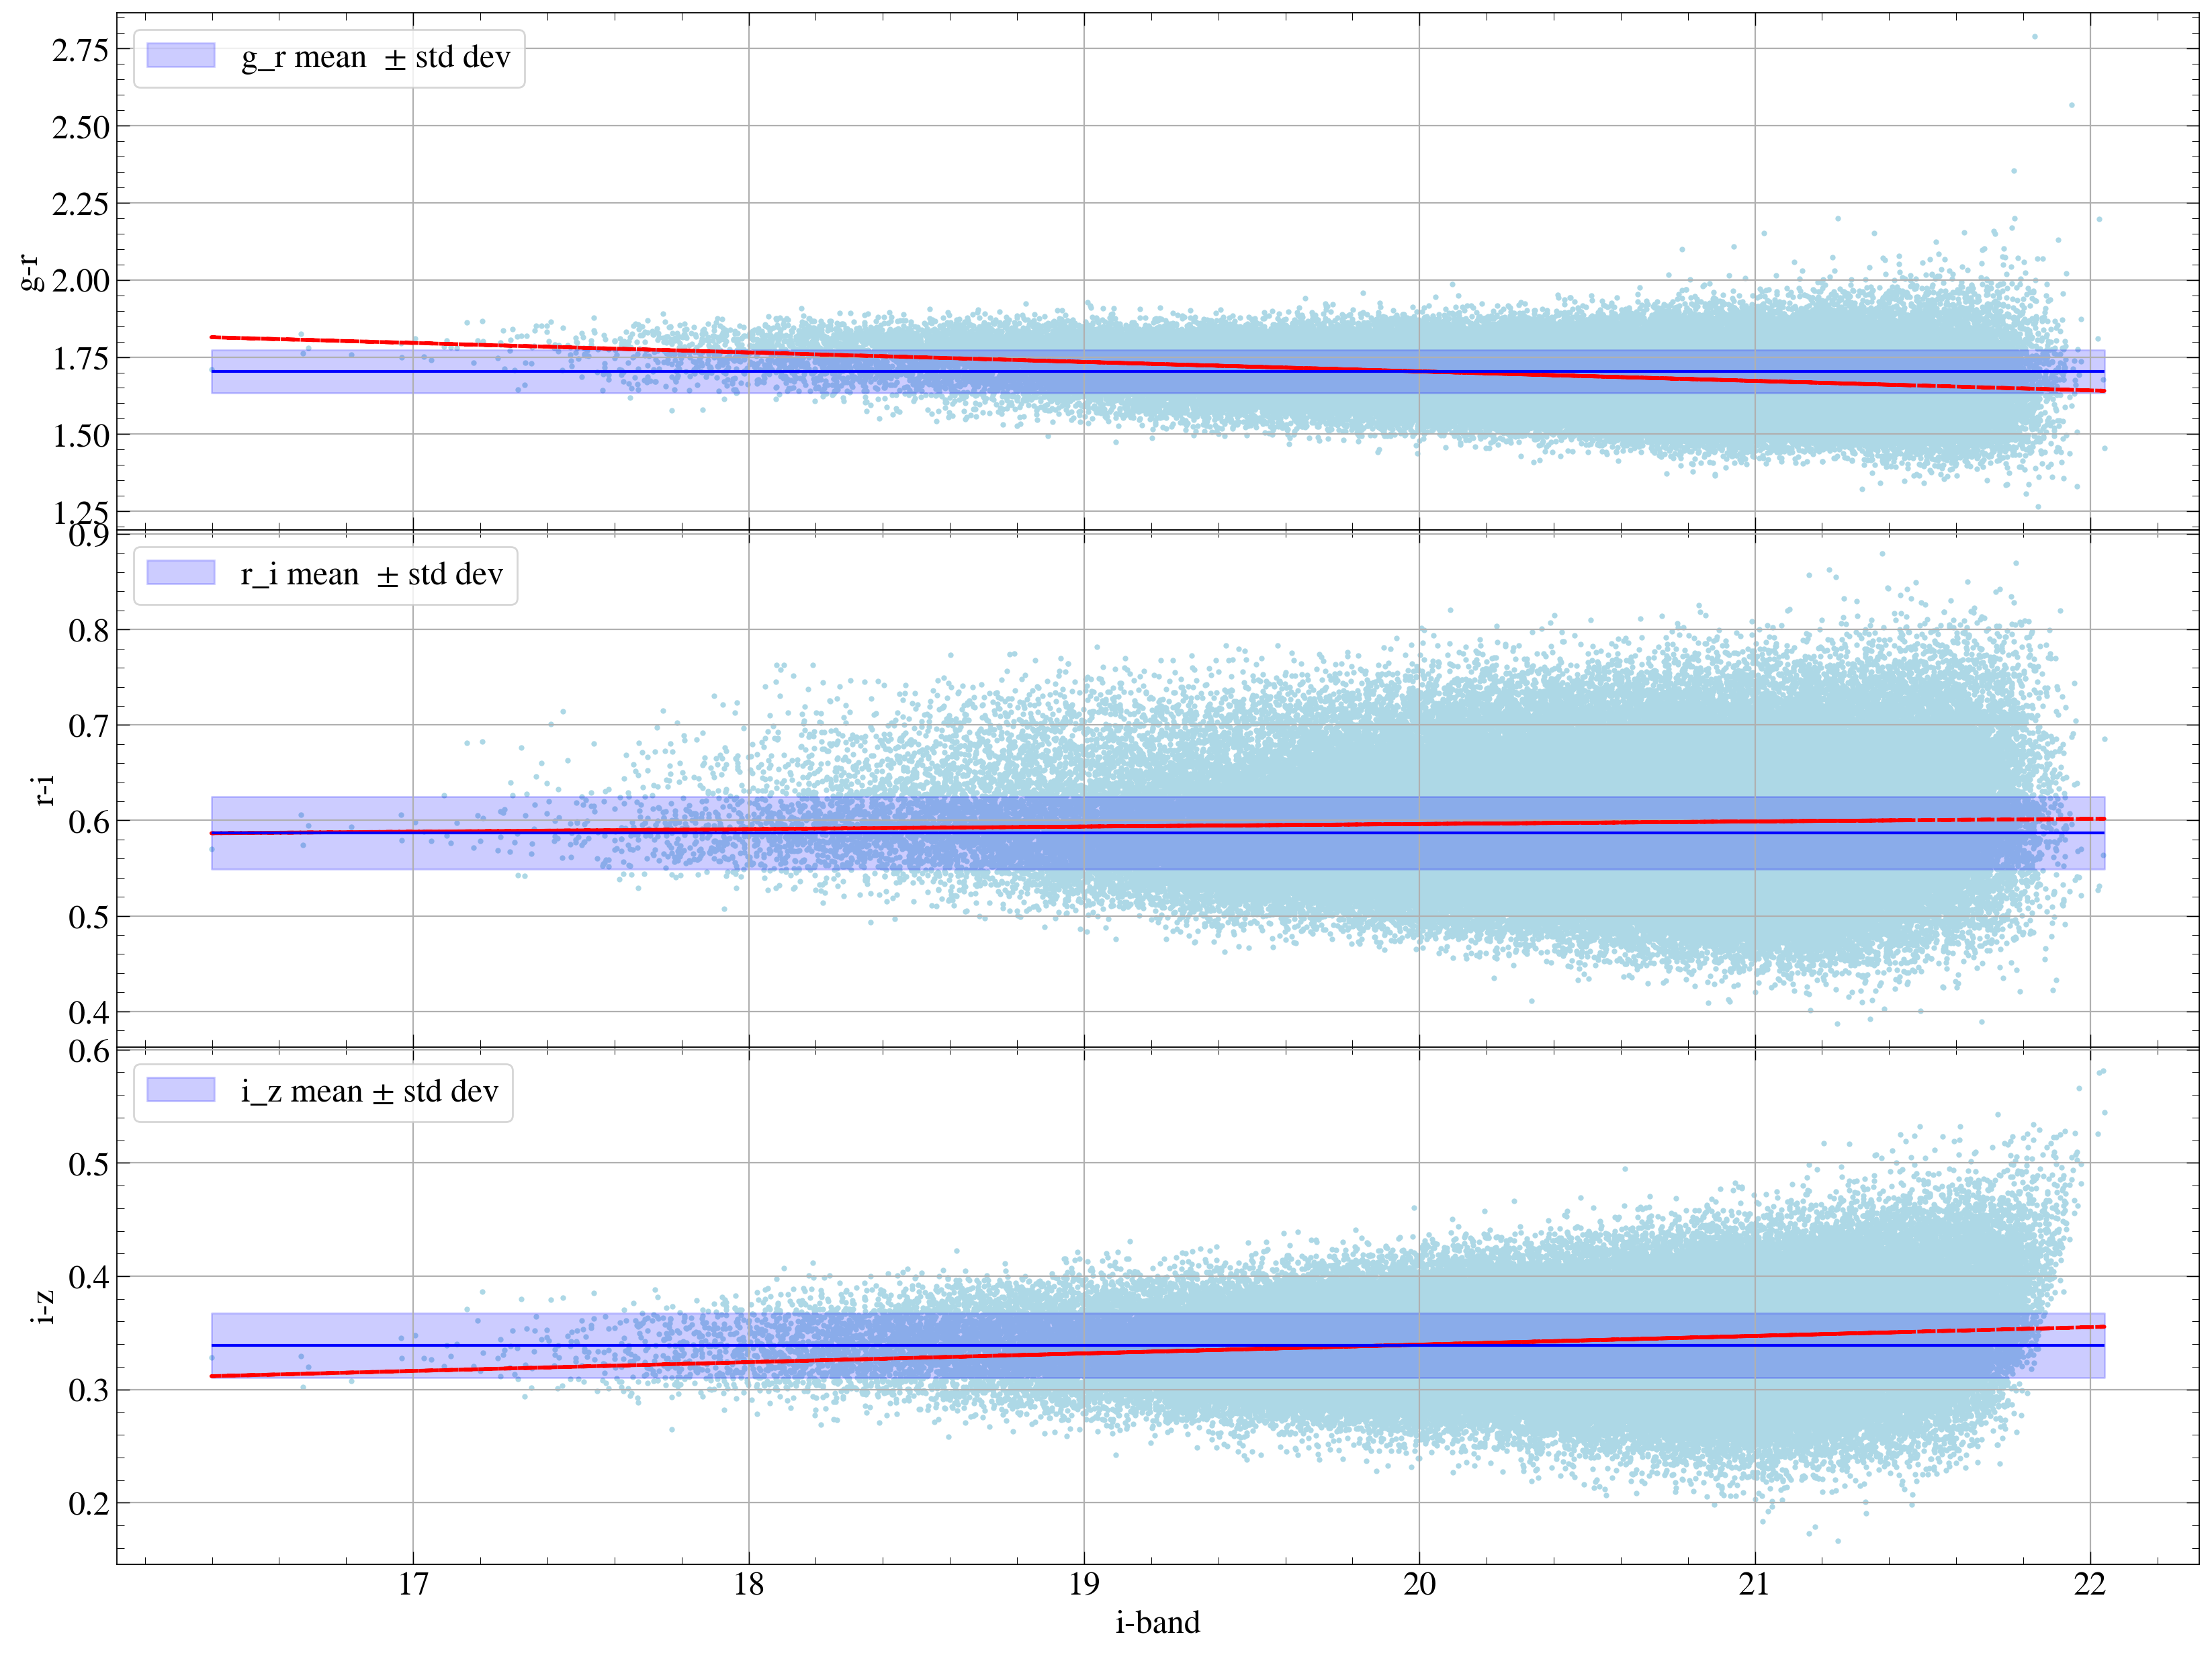

In [12]:
g_r_mean = 1.7032335957350702
g_r_std = 0.06880923228976833
r_i_mean = 0.5867762251074595
r_i_std = 0.038023286137249965
i_z_mean = 0.3387836075946875
i_z_std = 0.02862686872388944

## Color-index <0.5 is blue(hot) ; >1.5 is red(cold) galaxy colour magnitude diagram
x = i
y1 = g-r
y2 = r-i
y3 = i-z

#find line of best fit
a1, b1 = np.polyfit(x, y1, 1)
a2, b2 = np.polyfit(x, y2, 1)
a3, b3 = np.polyfit(x, y3, 1)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,15))
fig.subplots_adjust(hspace=0) # Remove horizontal space between axes

# Plot each graph, and manually set the y tick values
axs[0].scatter(x,y1, c='lightblue', s=4)
axs[0].plot(x, a1*x+b1, color='red', linestyle='--', linewidth=2)
axs[0].fill_between([min(x), max(x)], g_r_mean - g_r_std, g_r_mean + g_r_std, color='b', alpha=0.2, label='g_r mean  ± std dev')
axs[0].hlines(g_r_mean, min(x), max(x), color='b')
axs[0].set_ylabel('g-r')
axs[0].legend()

axs[1].scatter(x,y2, c='lightblue', s=4)
axs[1].plot(x, a2*x+b2, color='red', linestyle='--', linewidth=2)
axs[1].fill_between([min(x), max(x)], r_i_mean - r_i_std, r_i_mean + r_i_std, color='b', alpha=0.2, label='r_i mean  ± std dev')
axs[1].hlines(r_i_mean, min(x), max(x), color='b')
axs[1].set_ylabel('r-i')
axs[1].legend()

axs[2].scatter(x,y3, c='lightblue', s=4)
axs[2].plot(x, a3*x+b3, color='red', linestyle='--', linewidth=2)
axs[2].fill_between([min(x), max(x)], i_z_mean - i_z_std, i_z_mean + i_z_std, color='b', alpha=0.2, label='i_z mean ± std dev')
axs[2].hlines(i_z_mean, min(x), max(x), color='b')
axs[2].set_ylabel('i-z')
axs[2].set_xlabel('i-band')
plt.legend()
plt.show()

In [13]:
(0.5+0.35)/2

0.425

In [14]:
ra_all = redmapper_me['ra']
print('ra_all', len(ra_all))
dec_all = redmapper_me['dec']
z_all = redmapper_me['z']
mag_g_all = np.array([item[0] for item in np.array(redmapper_me['mag'])])
mag_r_all = np.array([item[1] for item in np.array(redmapper_me['mag'])])
mag_i_all = np.array([item[2] for item in np.array(redmapper_me['mag'])])
mag_z_all = np.array([item[3] for item in np.array(redmapper_me['mag'])])

#### Step 2: cut redshift and magnitude
## TODO: magnitude cut not working 
sel = (z_all >= 0.35)&(z_all <= 0.5) & (redmapper_me['p']>0.9) #& (mag_i_all > 10) & (mag_i_all < i_vs_redshift(self.zmid)) # & (mag_i_all > 10)&(mag_i_all < self.mag_i_cut) & (i_vs_redshift(self.zmid))
# print('the diff mag_cut', i_vs_redshift(self.zmid))
# print('done selection')
#         self.chi_gal = chi_all[sel]
ra_gal = ra_all[sel] # deg
print('self.ra_gal after z cut', len(ra_gal))
dec_gal = dec_all[sel] # deg

ra_all 1043744
self.ra_gal after z cut 43539


In [15]:
from magnitude_cut import mag_i_lim_Rykoff14
from member_color_interp import *
from Extraction_8 import galaxies

output_file_path = r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/debug/"
depth = 30
chisq_cut = 9 

############################################################################################
from member_color_interp import *
class AlternativeRichness(object):
    def __init__(self, zmin, zmax):#, sample, method, radius, depth, chisq_cut=chisq_cut):
        self.zmin = zmin
        self.zmax = zmax
        self.zmid = 0.5 * (self.zmin + self.zmax)
        self.save_name = 'z_%g_%g'%(self.zmin, self.zmax)

#         self.mag_i_cut = mag_i_lim_Rykoff14(zmin)

        self.richness_file = output_file_path+'ngal_%s.dat'%(self.save_name)

        self.halos = galaxies(pixel_id,xy)
        
#         self.chisq = None
        
    def plot_color_magnitude_diagram(self):
        g_r = self.gg_rr
        mag_i = self.mag_i_all

        # Calculate the mean and standard deviation for g-r color
        mean_g_r = self.g_r_mean
        std_g_r = self.g_r_std

        # Calculate the mean and standard deviation for mag_i magnitude
        mean_mag_i = np.mean(mag_i)
        std_mag_i = np.std(mag_i)

        # Create the color-magnitude diagram
        plt.figure(figsize=(10, 6))
        plt.scatter(mag_i, g_r, s=5, alpha=0.5, label='redmapper members')

        # Plot the mean point
        plt.scatter(mean_mag_i, mean_g_r, c='red', marker='o', label='Mean', s=100)

#         # Plot error bars for the mean point
#         plt.errorbar(mean_mag_i, mean_g_r, xerr=std_mag_i, yerr=std_g_r,
#             fmt='none', ecolor='blue', elinewidth=2, capsize=5, capthick=2, label='Std Dev')
        # Plot error bars for the mean point
        plt.errorbar( mean_mag_i, mean_g_r, yerr=std_g_r,
            fmt='none', ecolor='blue', elinewidth=2, capsize=5, capthick=2, label='Std Dev')
        
        plt.text(19, 2, f'Mean g-r: {mean_g_r:.2f}\nStd g-r: {std_g_r:.2f}', fontsize=12)
        plt.ylabel('g-r')
        plt.xlabel('mag_i')
        plt.title('Color-Magnitude Diagram')
        plt.legend()
        plt.grid(True)
        plt.show()

        
    def get_galaxies(self):
        p_all = redmapper_me['p']
        ra_all = redmapper_me['ra']
        print('ra_all', len(ra_all))
        dec_all = redmapper_me['dec']
        z_all = redmapper_me['z']
        mag_g_all = np.array([item[0] for item in np.array(redmapper_me['mag'])])
        mag_r_all = np.array([item[1] for item in np.array(redmapper_me['mag'])])
        mag_i_all = np.array([item[2] for item in np.array(redmapper_me['mag'])])
        mag_z_all = np.array([item[3] for item in np.array(redmapper_me['mag'])])
       
      #### Step 2: cut redshift and magnitude 
        sel = (z_all >= self.zmin)&(z_all <= self.zmax) & (p_all>=0.9) & (mag_i_all > 10) & (mag_i_all < i_vs_redshift(self.zmid)) # & (mag_i_all > 10)&(mag_i_all < self.mag_i_cut) & (i_vs_redshift(self.zmid))
        print('the diff mag_cut', i_vs_redshift(self.zmid))
        self.ra_gal = ra_all[sel] # deg
        print('self.ra_gal after z cut', len(self.ra_gal))
        self.dec_gal = dec_all[sel] # deg

        #### Step 3: cut color chisq based on the color templates 
        ## TODO for Heidi & Gladys: there might be a bug in color templates
        g_r_mean = g_r_vs_redshift(self.zmid)
        self.g_r_mean = g_r_mean
        print('g_r_mean', g_r_mean, g_r_mean**2)
        g_r_std = sigma_g_r_vs_redshift(self.zmid)
        self.g_r_std = g_r_std
        print('g_r_std', g_r_std, g_r_std**2)
        r_i_mean = r_i_vs_redshift(self.zmid)
        print('r_i_mean', r_i_mean, r_i_mean**2)
        r_i_std = sigma_r_i_vs_redshift(self.zmid)
        print('r_i_std', r_i_std, r_i_std**2)

        i_z_mean = i_z_vs_redshift(self.zmid)
        print('i_z_mean', i_z_mean, i_z_mean**2)
        i_z_std = sigma_i_z_vs_redshift(self.zmid)
        print('i_z_std', i_z_std, i_z_std**2)

        g_r = mag_g_all[sel] - mag_r_all[sel]
        self.gg_rr = mag_g_all[sel] - mag_r_all[sel]
        r_i = mag_r_all[sel] - mag_i_all[sel]
        i_z = mag_i_all[sel] - mag_z_all[sel]
        self.mag_i_all = mag_i_all[sel]
        print('g_r', g_r, min(g_r), max(g_r), np.mean(g_r), len(g_r))
        print('r_i', r_i, min(r_i), max(r_i), np.mean(r_i), len(r_i))
        print('i_z', i_z, min(i_z), max(i_z), np.mean(i_z), len(i_z))

        chisq = (g_r - g_r_mean)**2 / g_r_std**2
        chisq += (r_i - r_i_mean)**2 / r_i_std**2
        chisq += (i_z - i_z_mean)**2 / i_z_std**2
        self.chisq = chisq
        print('chisq', chisq, min(chisq), max(chisq), np.mean(chisq), len(chisq))
        
        
        
        sel2 = (chisq < chisq_cut)
        print('sum(sel2)', sum(sel2))

        self.ra_gal = self.ra_gal[sel2] * np.pi / 180.
        self.dec_gal = self.dec_gal[sel2] * np.pi / 180.

def run_parallel():
    zmin = 0.35
    zmax = 0.5
    car = AlternativeRichness(zmin=zmin, zmax=zmax)
    car.get_galaxies()
    car.plot_color_magnitude_diagram()

run_parallel()

NameError: name 'pixel_id' is not defined

In [16]:
redshift_bin = np.linspace(0.1,0.95,19)  ##0.2, 17
labels = np.round(np.arange(0.1, 1, 0.1/2),2).tolist()
print(labels, len(labels))
redshift_bin, len(redshift_bin)

[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95] 18


(array([0.1       , 0.14722222, 0.19444444, 0.24166667, 0.28888889,
        0.33611111, 0.38333333, 0.43055556, 0.47777778, 0.525     ,
        0.57222222, 0.61944444, 0.66666667, 0.71388889, 0.76111111,
        0.80833333, 0.85555556, 0.90277778, 0.95      ]),
 19)

In [17]:
redmapper_me3 = redmapper_me[(redmapper_me['p']>0.9) & (redmapper_me['z']>0.2)]
print(len(redmapper_me3))
mag = Table()
mag['g'] = np.array([item[0] for item in np.array(redmapper_me3['mag'])])
mag['r'] = np.array([item[1] for item in np.array(redmapper_me3['mag'])])
mag['i'] = np.array([item[2] for item in np.array(redmapper_me3['mag'])])
mag['z'] = np.array([item[3] for item in np.array(redmapper_me3['mag'])])
mag['redshift'] = np.array(redmapper_me3['z'])

112074


In [18]:
print((mag['g']).min(), (mag['g']).max())
print((mag['r']).min(), (mag['r']).max())
print((mag['i']).min(), (mag['i']).max())
print((mag['z']).min(), (mag['z']).max())

17.706347 28.71363
16.292122 24.75553
15.820626 23.53788
15.483568 22.917166


In [19]:
mag['g_r'] = mag['g'] - mag['r']
mag['r_i'] = mag['r'] - mag['i']
mag['i_z'] = mag['i'] - mag['z']
mag['redshift_bins'] = pd.cut(mag['redshift'], bins=redshift_bin, labels=labels, include_lowest=True)

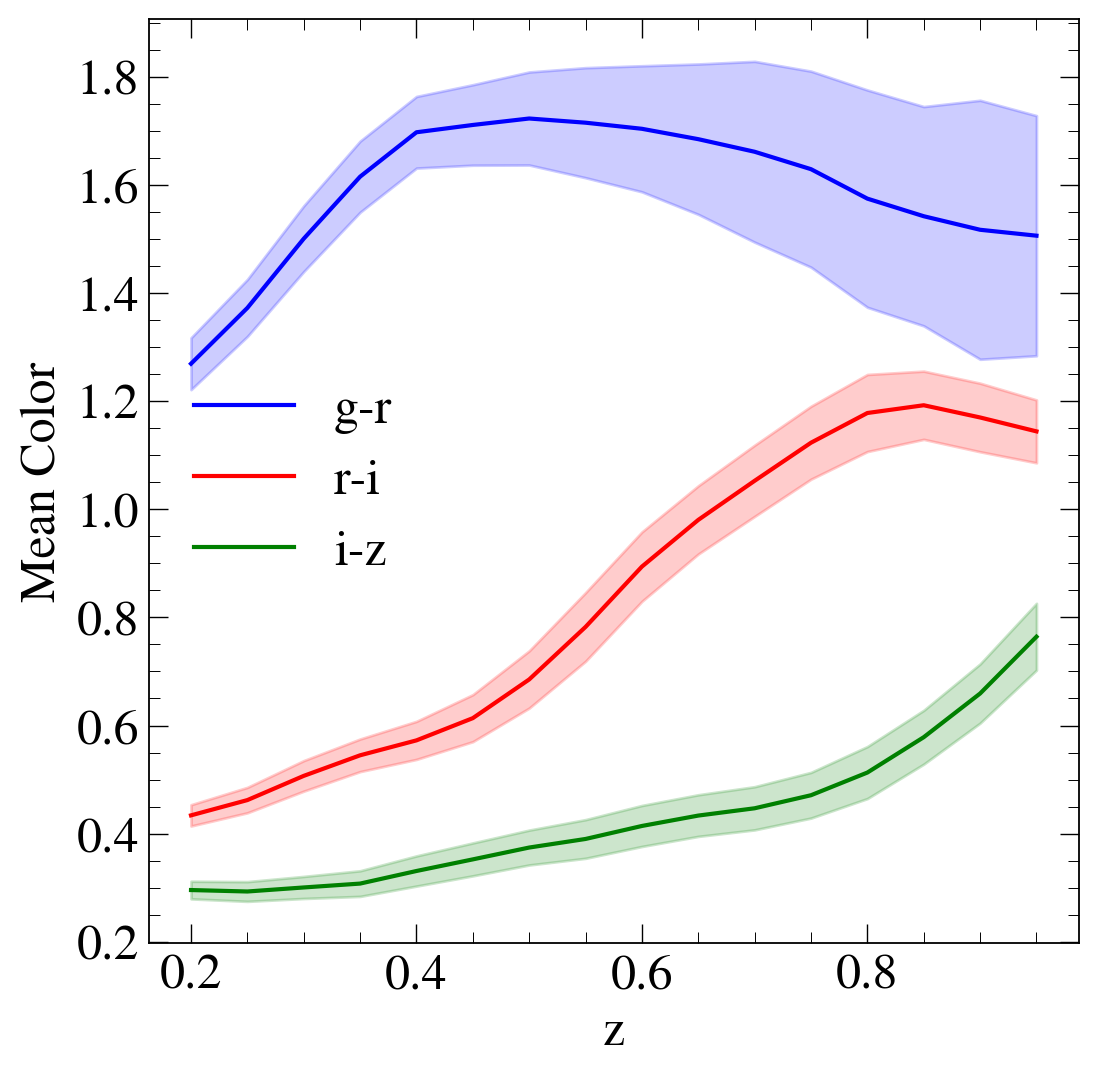

In [21]:
grouped_table = mag.group_by('redshift_bins')
median = grouped_table['g_r','r_i','i_z','redshift','redshift_bins'].groups.aggregate(np.median)
mean = grouped_table['g_r','r_i','i_z','redshift','redshift_bins'].groups.aggregate(np.mean)
err = grouped_table['g_r','r_i','i_z','redshift_bins'].groups.aggregate(np.std)
err.rename_columns(['g_r','r_i','i_z'], ['gr_err','ri_err','iz_err'])

# plt.figure(figsize=(12,8))
X_m = mean['redshift_bins']
Yg = mean['g_r']
Yr = mean['r_i']
Yi = mean['i_z']

plt.plot(X_m,Yg, c='blue', label='g-r')
plt.fill_between(X_m,Yg+err['gr_err'],Yg-err['gr_err'], color='blue', alpha=0.2)
plt.plot(X_m,Yr, c='red', label='r-i')
plt.fill_between(X_m,Yr+err['ri_err'],Yr-err['ri_err'], color='red', alpha=0.2)
plt.plot(X_m,Yi, c='green', label='i-z')
plt.fill_between(X_m,Yi+err['iz_err'],Yi-err['iz_err'], color='green', alpha=0.2)
plt.ylabel('Mean Color')
plt.xlabel('z')
plt.legend(frameon=False)
plt.grid()
filep = r'/bsuhome/gladyskamau/BSU-Research/Cardinal/'
plt.savefig(filep + 'Images/cardinal_redSequence.png', facecolor='white')
plt.show()

## Cylinder Depth - color templates

In [72]:
# ## Sigma and DS profile
# file_path = r"/global/u1/k/kamau/SE-CLMM-LSSTDESC/cosmoDC2/Data/"
# # Reading the halos data
# a,b,c,d,e,f,g = np.loadtxt(file_path + 'halos/cluster_halo_2086.dat', unpack=True, skiprows=0+1)

In [22]:
full_mag = join(mag,err, keys=['redshift_bins'])
print(len(full_mag))
full_mag[:5]

112074


g,r,i,z,redshift,g_r,r_i,i_z,redshift_bins,gr_err,ri_err,iz_err
float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32
21.155481,19.961924,19.546007,19.258696,0.21823922,1.1935577,0.41591644,0.28731155,0.2,0.050278306,0.020159638,0.016170977
21.247704,20.046528,19.626135,19.339224,0.21823922,1.2011757,0.420393,0.286911,0.2,0.050278306,0.020159638,0.016170977
20.145615,18.897732,18.450554,18.146078,0.21823922,1.2478828,0.4471779,0.30447578,0.2,0.050278306,0.020159638,0.016170977
21.325975,20.117704,19.686533,19.403658,0.21823922,1.208271,0.43117142,0.28287506,0.2,0.050278306,0.020159638,0.016170977
21.311892,20.06648,19.659456,19.344212,0.21823922,1.2454109,0.40702438,0.31524467,0.2,0.050278306,0.020159638,0.016170977


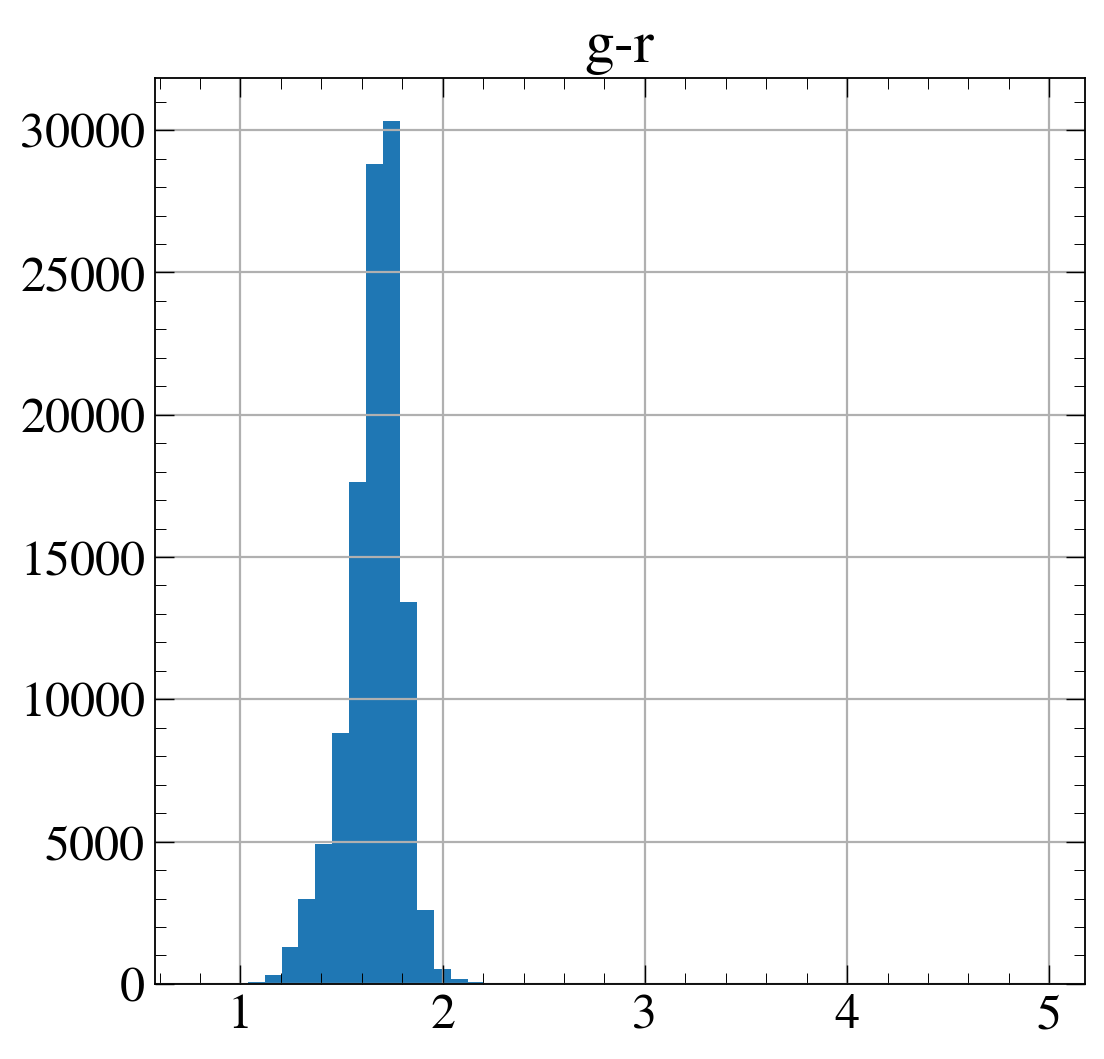

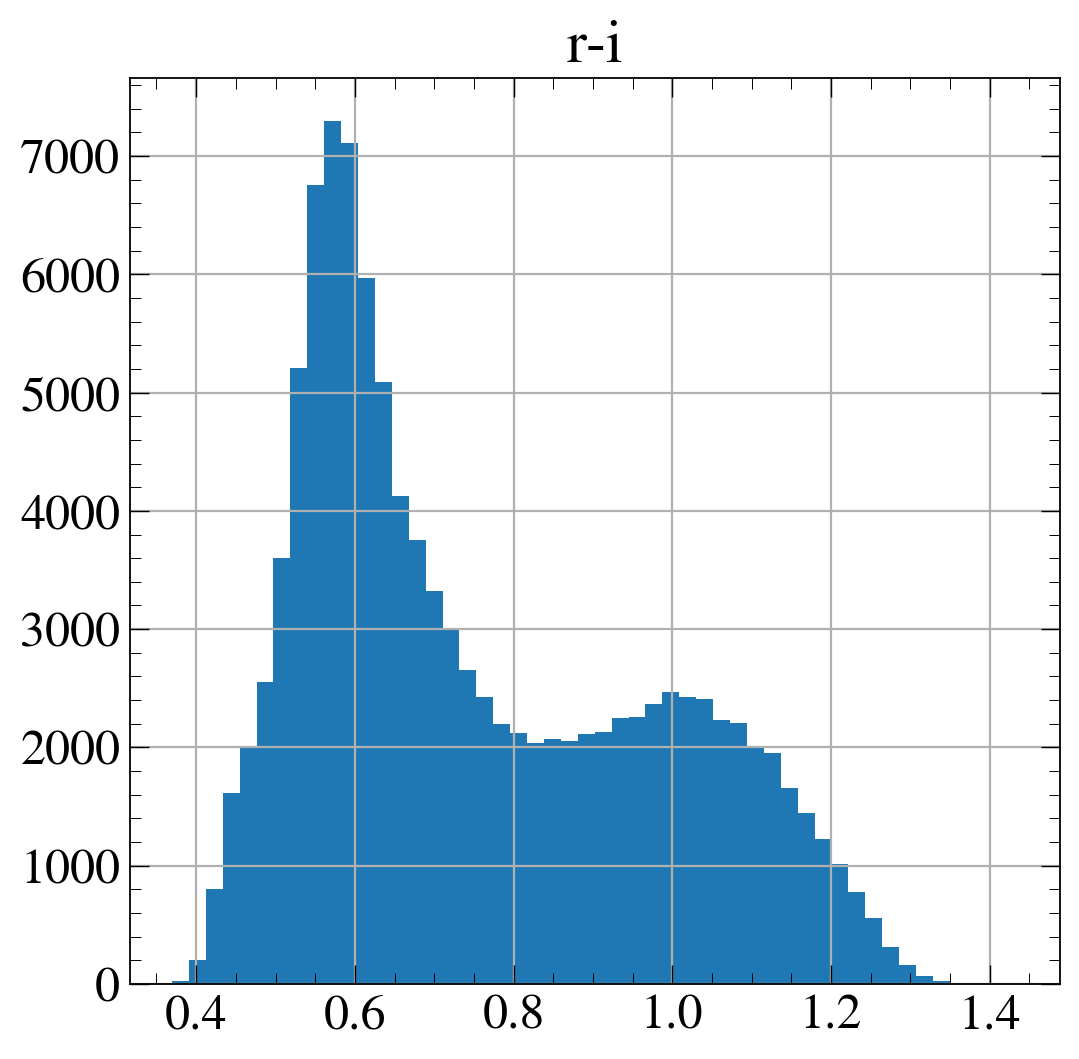

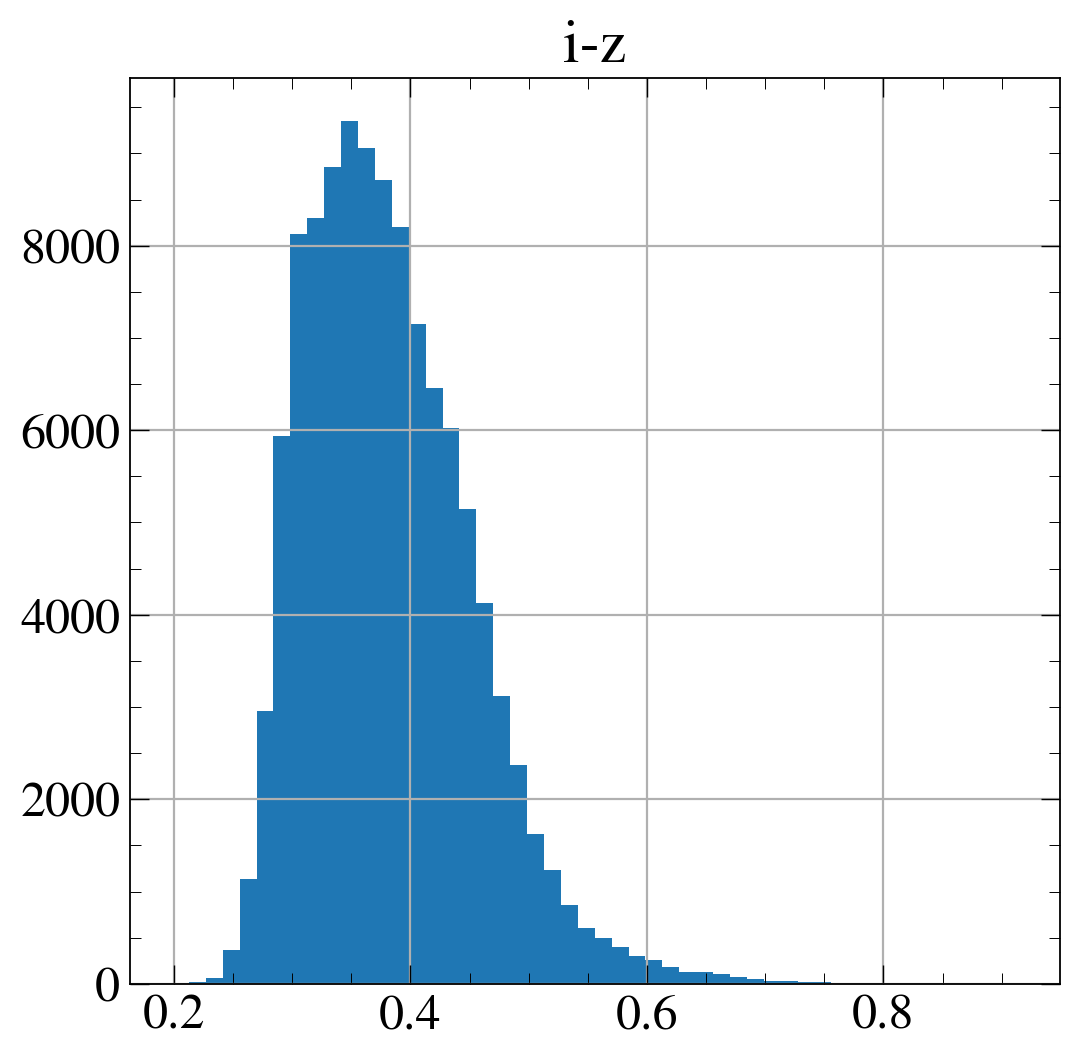

In [37]:
plt.hist(full_mag['g_r'], bins=50)
plt.title('g-r')
plt.show()
plt.hist(full_mag['r_i'], bins=50)
plt.title('r-i')
plt.show()
plt.hist(full_mag['i_z'], bins=50)
plt.title('i-z')
plt.show()

In [14]:
mean['grlow'], mean['grhigh'] = mean['g_r']-err['gr_err'], mean['g_r']+err['gr_err']
mean['rilow'], mean['rihigh'] = mean['r_i']-err['ri_err'], mean['r_i']+err['ri_err']
mean['izlow'], mean['izhigh'] = mean['i_z']-err['iz_err'], mean['i_z']+err['iz_err']

In [15]:
mag_gr = mean['redshift', 'g_r', 'grlow', 'grhigh']
mag_ri = mean['redshift', 'r_i', 'rilow', 'rihigh']
mag_iz = mean['redshift', 'i_z', 'izlow', 'izhigh']
print(len(mag_gr))

18


In [16]:
mag_ri

redshift,r_i,rilow,rihigh
float64,float64,float64,float64
0.121555121591158,0.39243936984338496,0.3762992422888491,0.4085794973979208
0.1715834776241937,0.3976711357284882,0.3809790076960423,0.41436326376093413
0.22534145349859352,0.43242451041391966,0.4121641093438017,0.4526849114840376
0.26470510776226336,0.46210872209989107,0.43860634989463365,0.4856110943051485
0.31334234671226485,0.5068780323439924,0.47863479051233215,0.5351212741756527
0.36111579255729576,0.5449180913654124,0.5147854568001782,0.5750507259306465
0.40881570107844534,0.5725412178087825,0.5373553182232971,0.607727117394268
0.45449690912595864,0.6136475830485162,0.5701726182510194,0.657122547846013
0.5004513634957246,0.685217319808904,0.6322856087312139,0.7381490308865941


In [17]:
mag_gr

redshift,g_r,grlow,grhigh
float64,float64,float64,float64
0.121555121591158,0.9638218959915303,0.9231717480468415,1.0044720439362191
0.1715834776241937,1.1050323302855711,1.0610134023239832,1.149051258247159
0.22534145349859352,1.2632786231704904,1.2113097506233408,1.31524749571764
0.26470510776226336,1.372343503511869,1.319610939002954,1.425076068020784
0.31334234671226485,1.5003924432699767,1.4396345492010203,1.561150337338933
0.36111579255729576,1.6150690494073416,1.5493285087836768,1.6808095900310065
0.40881570107844534,1.6971866546839407,1.6309742389887503,1.7633990703791311
0.45449690912595864,1.710716723282761,1.6362963978247111,1.7851370487408107
0.5004513634957246,1.7226461077598145,1.63662043013845,1.8086717853811791


In [6]:
file_path =  r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/"
# mag_gr.write(file_path + 'g_r_05.dat', format='ascii')
# mag_ri.write(file_path + 'r_i_05.dat', format='ascii')
# mag_iz.write(file_path + 'i_z_05.dat', format='ascii')

# Investigating the magnitude cut and color cut

In [45]:
import healpy as hp
skysim = gcr.load_catalog('skysim5000_v1.1.1')

hpix = 6080
nside = 32
hpix_list = skysim.available_healpix_pixels
hpix_neighbors = hp.pixelfunc.get_all_neighbours(nside, hpix)
hpix_toread = list(set(hpix_list) & set(hpix_neighbors))
hpix_toread.append(hpix)
# print(hpix_toread)

## Getting the galaxies
ra_all = []
dec_all = []
z_all = []
mag_g_all = []
mag_r_all = []
mag_i_all = []
mag_z_all = []
mag_y_all = []

## getting galaxies
for hpix_i in hpix_toread:
    galaxy_data = skysim.get_quantities(['redshift','ra', 'dec','mag_true_g','mag_true_r',
                                         'mag_true_i','mag_true_z','mag_true_y'], 
                                        native_filters=f'healpix_pixel == {hpix_i}')

    ra_all.extend(galaxy_data['ra'])
    dec_all.extend(galaxy_data['dec'])
    z_all.extend(galaxy_data['redshift'])
    mag_g_all.extend(galaxy_data['mag_true_g'])
    mag_r_all.extend(galaxy_data['mag_true_r'])
    mag_i_all.extend(galaxy_data['mag_true_i'])
    mag_z_all.extend(galaxy_data['mag_true_z'])
    mag_y_all.extend(galaxy_data['mag_true_y'])
    
ra_all = np.array(ra_all)
dec_all = np.array(dec_all)
z_all = np.array(z_all)
mag_g_all = np.array(mag_g_all)
mag_r_all = np.array(mag_r_all)
mag_i_all = np.array(mag_i_all)
mag_z_all = np.array(mag_z_all)
mag_y_all = np.array(mag_y_all)   
    
print(len(mag_i_all))

19529286


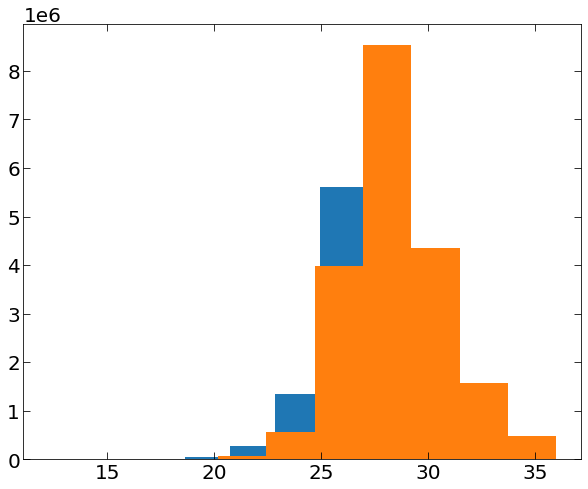

In [46]:
plt.hist(mag_i_all)
plt.hist(mag_g_all)
plt.show()

In [81]:
zmin, zmax = 0.3, 0.32

sel = (z_all >= zmin-0.1)&(z_all <= zmax+0.1) # &(mag_i_all > 10)&(mag_i_all < mag_i_cut)
# z1 = gals_fil['redshift']

i = mag_i_all[sel]
g_r = mag_g_all[sel] - mag_r_all[sel]
r_i = mag_r_all[sel] - mag_i_all[sel]
i_z = mag_i_all[sel] - mag_z_all[sel]
z_y = mag_z_all[sel] - mag_y_all[sel]
grhigh = g_r + np.std(g_r)
grlow = g_r - np.std(g_r)

print(len(i), len(g_r))

##################################################################################
# from member_color_interp import *
chisq_cut = 9

g_r_mean = g_r_vs_redshift(zmin)
r_i_mean = r_i_vs_redshift(zmin)
g_r_std = sigma_g_r_vs_redshift(zmin)

chisq1 = (g_r - g_r_mean)**2 / g_r_std**2

sel2 = (chisq1 < chisq_cut)

print(len(chisq1), len(sel2),r_i_mean)

ra_gal1 = ra_all[sel]

ra_gal = ra_gal1[sel2] * np.pi / 180.

print('done selecting galaxies, ngals = ', len(ra_gal))

312152 312152
312152 312152 0.580414179272265
done selecting galaxies, ngals =  25886


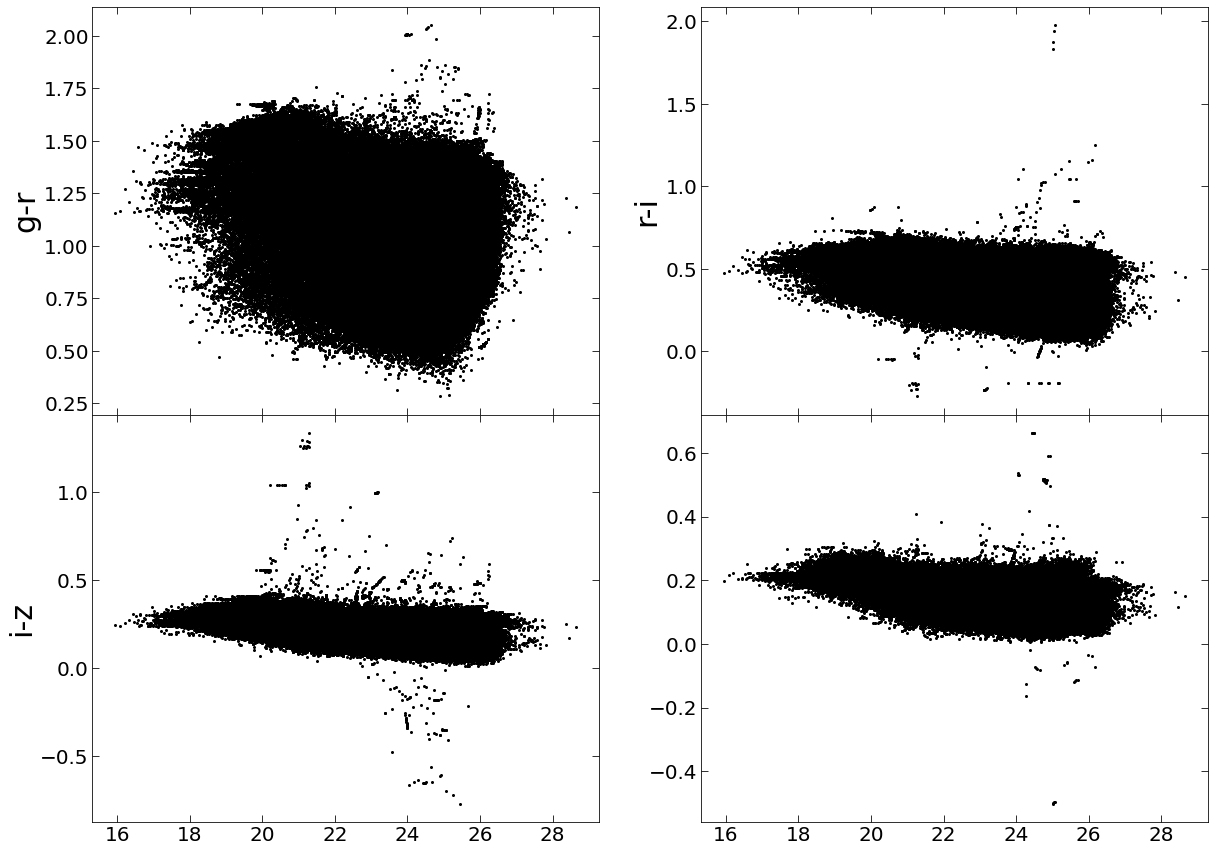

In [82]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(20,15))
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
axs[0][0].scatter(z, g_r, c='k', s=4)
axs[0][0].set_ylabel('g-r')

axs[0][1].scatter(z, r_i, c='k', s=4)
axs[0][1].set_ylabel('r-i')

axs[1][0].scatter(z, i_z, c='k', s=4)
axs[1][0].set_ylabel('i-z')

axs[1][1].scatter(z, z_y, c='k', s=4)

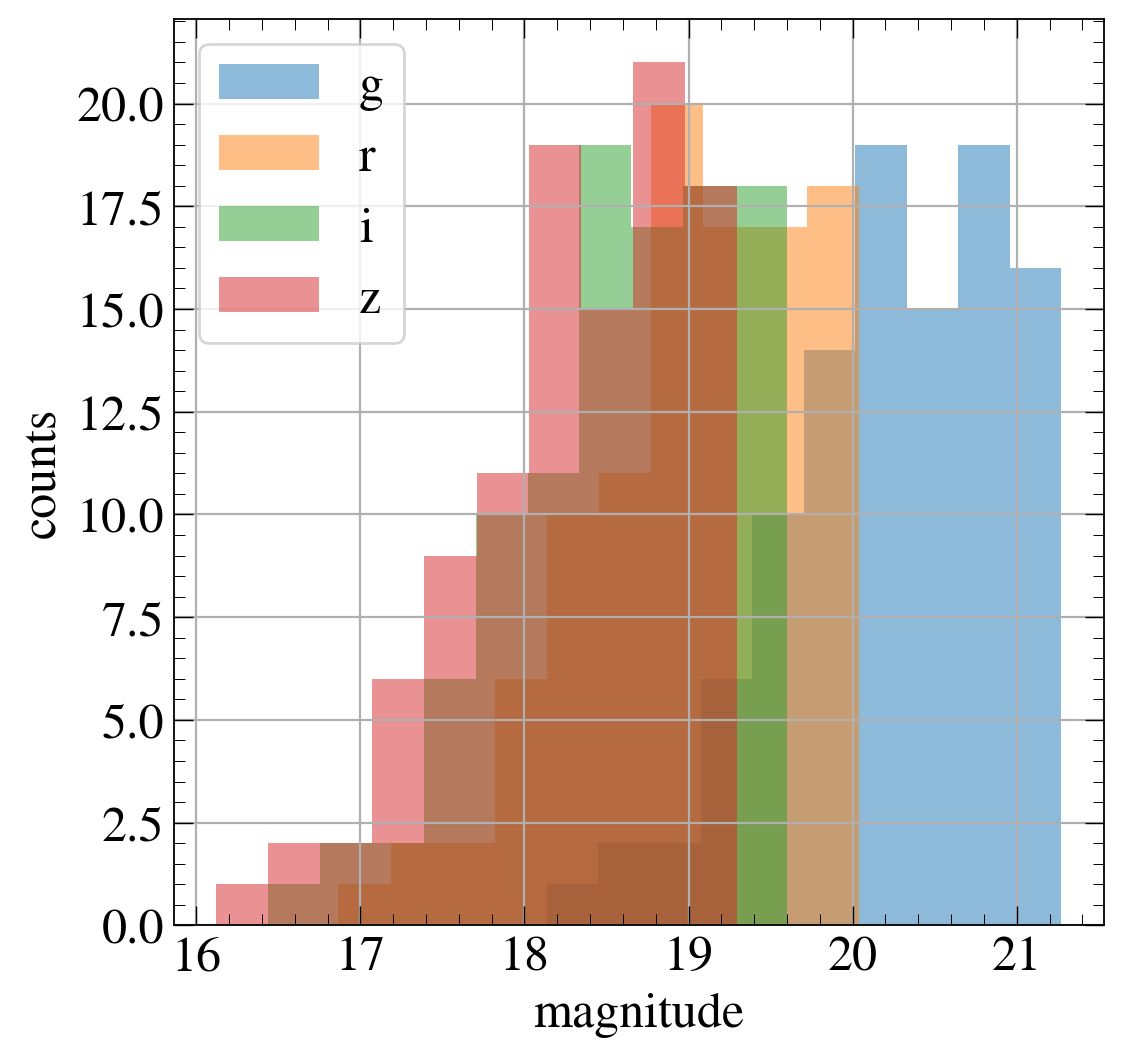

In [5]:
redmapper_me1 = redmapper_me[(redmapper_me['z']>0.2) & (redmapper_me['z']<0.21) & (redmapper_me['p']>0.9)] #(redmapper_me['z']<0.205) & 
bands = ['g','r','i','z']

# for indx in range(5):
#     me_band = [i[indx] for i in redmapper_me1['mag']]
#     print(np.max(me_band))
#     # print(np.min(me_band))
#     plt.hist(me_band, bins=30, label=bands[indx], alpha=0.5, rwidth=1)
plt.hist( np.array([item[0] for item in np.array(redmapper_me1['mag'])]), bins=10, label='g', alpha=0.5, rwidth=1)
plt.hist( np.array([item[1] for item in np.array(redmapper_me1['mag'])]), bins=10, label='r', alpha=0.5, rwidth=1)
plt.hist( np.array([item[2] for item in np.array(redmapper_me1['mag'])]), bins=10, label='i', alpha=0.5, rwidth=1)
plt.hist( np.array([item[3] for item in np.array(redmapper_me1['mag'])]), bins=10, label='z', alpha=0.5, rwidth=1)
plt.xlabel('magnitude')
plt.ylabel('counts')
plt.legend()
plt.show()

In [6]:
redmapper_me2 = redmapper_me[(redmapper_me['z']>=0.1)  & (redmapper_me['p']>0.9)]
# redmapper_me2.rename_column('z', 'zz')
print(len(redmapper_me2))
redmapper_me2['g'] = np.array([item[0] for item in np.array(redmapper_me2['mag'])])
redmapper_me2['r'] = np.array([item[1] for item in np.array(redmapper_me2['mag'])])
redmapper_me2['i'] = np.array([item[2] for item in np.array(redmapper_me2['mag'])])
redmapper_me2['zz'] = np.array([item[3] for item in np.array(redmapper_me2['mag'])])

redshift_bin = np.linspace(0.1,1, 19)
labels = np.round(redshift_bin[:-1],2).tolist()
# print(redshift_bin, len(labels))
redmapper_me2['z_bins'] = pd.cut(redmapper_me2['z'], bins=redshift_bin, labels=labels, include_lowest=True)

grouped_table = redmapper_me2.group_by('z_bins')
mag_max = grouped_table['g','r','i','zz','z','z_bins'].groups.aggregate(np.max)
mag_min = grouped_table['g','r','i','zz','z','z_bins'].groups.aggregate(np.max)

113203


In [7]:
mag_max

g,r,i,zz,z,z_bins
float32,float32,float32,float32,float32,float64
20.143736,19.114466,18.72935,18.443146,0.14568678,0.1
21.053825,19.901527,19.48385,19.174953,0.19915517,0.15
21.847254,20.511137,20.057571,19.737244,0.24985631,0.2
22.482492,20.97991,20.499596,20.206293,0.29966906,0.25
23.151636,21.48393,20.943771,20.614883,0.34979174,0.3
23.717613,21.877787,21.32429,20.947138,0.39997053,0.35
24.058598,22.233313,21.655708,21.279446,0.4499795,0.4
24.5489,22.69643,22.021702,21.534134,0.49997836,0.45
25.049356,22.993176,22.23058,21.757162,0.54998064,0.5


In [8]:
iband_max = mag_max['i','z']
print(len(iband_max))
# iband_max.write(file_path + 'iband_max_05.dat', format='ascii')

17


In [16]:
from scipy.interpolate import interp1d
from magnitude_cut import mag_i_lim_Rykoff14
file_path =  r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/"

i , redshift = np.loadtxt(file_path + 'iband_max_01_1.dat',skiprows=1, unpack=True)
i_vs_redshift = interp1d(redshift, i)

i_02 , redshift_02 = np.loadtxt(file_path + 'gband_max.txt',skiprows=1, unpack=True)
i_vs_redshift_02 = interp1d(redshift_02, i_02)

mag_i_cut = i_vs_redshift(mag_max['z'][1:])
mag_i_cut_02 = i_vs_redshift_02(mag_max['z_bins'][3:])

mag_i_cut_Rykoff = [mag_i_lim_Rykoff14(z) for z in mag_max['z_bins']]

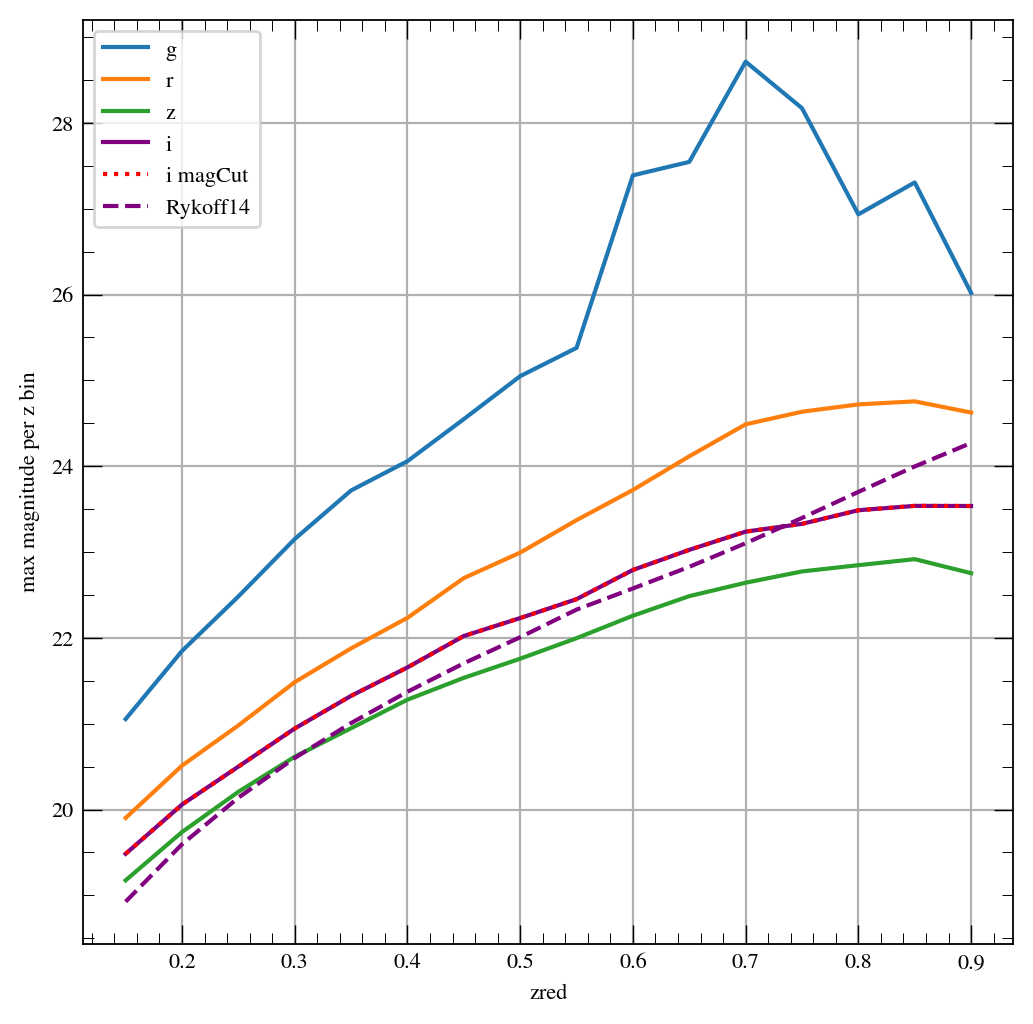

In [17]:
plt.plot(mag_max['z_bins'][1:], mag_max['g'][1:], label='g')
plt.plot(mag_max['z_bins'][1:], mag_max['r'][1:], label='r')
plt.plot(mag_max['z_bins'][1:], mag_max['zz'][1:], label='z')
plt.plot(mag_max['z_bins'][1:], mag_max['i'][1:], label='i', c='purple')
plt.plot(mag_max['z_bins'][1:], mag_i_cut, label='i magCut', c='r', linestyle=':') #(0.1<z<1)
# plt.plot(mag_max['z_bins'][3:], mag_i_cut_02, label='i magCut(0.2<z<1)', c='purple', linestyle='-.')
plt.plot(mag_max['z_bins'][1:], mag_i_cut_Rykoff[1:], label='Rykoff14', c='purple', linestyle='--')
plt.xlabel('zred')
# plt.title('')
plt.ylabel('max magnitude per z bin')
plt.legend()
plt.show()

In [57]:
mag_max

g,r,i,zz,z,z_bins
float32,float32,float32,float32,float32,float64
20.143736,19.114466,18.72935,18.443146,0.14568678,0.1
21.053825,19.901527,19.48385,19.174953,0.19915517,0.15
21.847254,20.511137,20.057571,19.737244,0.24985631,0.2
22.482492,20.97991,20.499596,20.206293,0.29966906,0.25
23.151636,21.48393,20.943771,20.614883,0.34979174,0.3
23.717613,21.877787,21.32429,20.947138,0.39997053,0.35
24.058598,22.233313,21.655708,21.279446,0.4499795,0.4
24.5489,22.69643,22.021702,21.534134,0.49997836,0.45
25.049356,22.993176,22.23058,21.757162,0.54998064,0.5


# color-magnitude for the members

In [14]:
from magnitude_cut import mag_i_lim_Rykoff14
from member_color_interp import *

In [22]:
me_sel = redmapper_me[(redmapper_me['p']>=0.5) & (redmapper_me['z']>=0.1) & (redmapper_me['z']<=1)]
mag_g = np.array([item[0] for item in np.array(me_sel['mag'])])
mag_r = np.array([item[1] for item in np.array(me_sel['mag'])])
mag_i = np.array([item[2] for item in np.array(me_sel['mag'])])
mag_z = np.array([item[3] for item in np.array(me_sel['mag'])]) 


print((mag_g).min(), (mag_g).max())
print((mag_r).min(), (mag_r).max())
print((mag_i).min(), (mag_i).max())
print((mag_z).min(), (mag_z).max())
print((redshift).min(), (redshift).max())
print( len(me_sel['z']))

15.586142 28.71363
14.645868 25.211279
14.230894 24.041954
13.93753 23.13444
0.1456867754459381 0.9422158598899841
485132


485132
485132 485132 485132 485132 485132
the diff mag_cut 22.04267900136344 22.007530112873333
g_r_mean 1.7218852171951118
g_r_std 0.08757062098421166
r_i_mean 0.6947607770858483
r_i_std 0.05397047527310185
i_z_mean 0.3758874613037801
i_z_std 0.03257623627874522


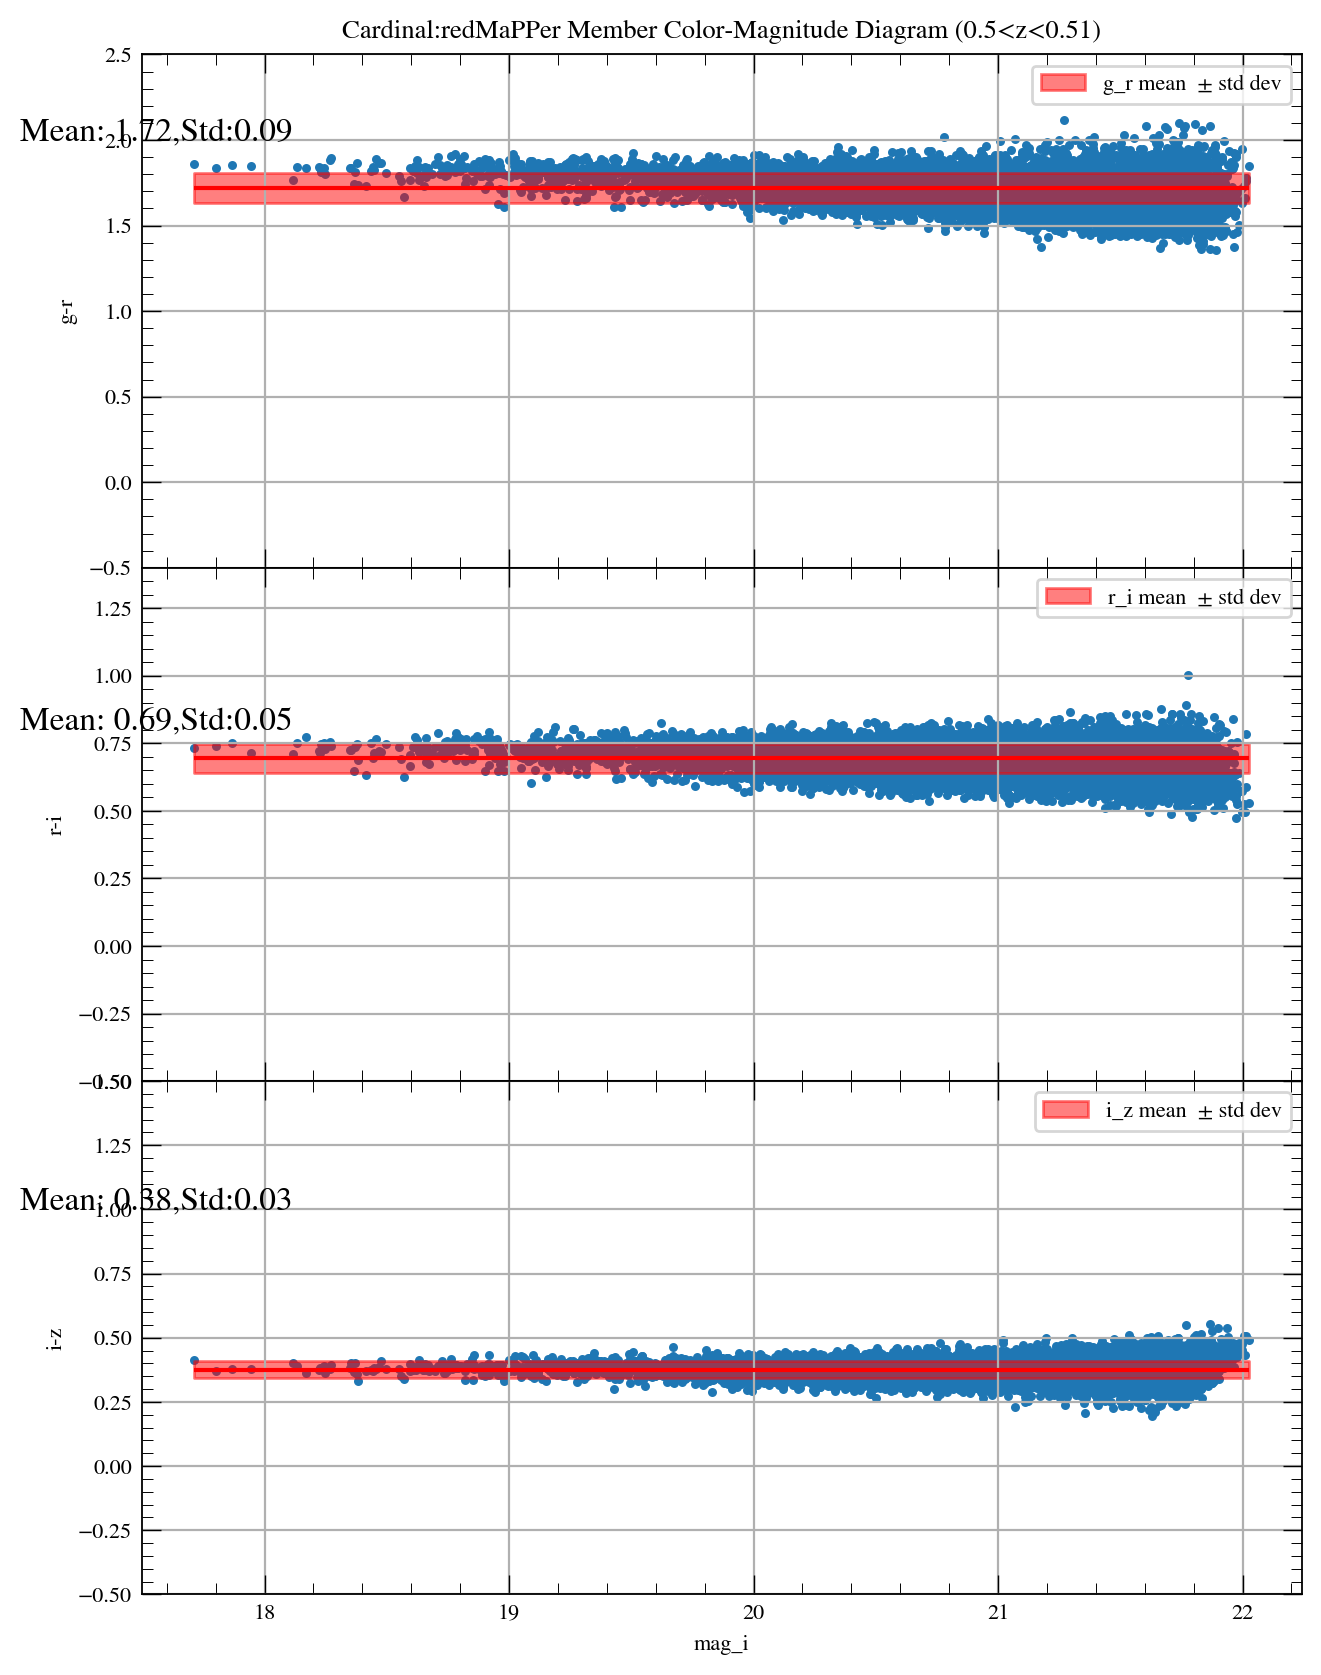

In [27]:
############################################################################################
from member_color_interp import *
class AlternativeRichness(object):
    def __init__(self, zmin, zmax):
        self.zmin = zmin
        self.zmax = zmax
        self.zmid = 0.5 * (self.zmin + self.zmax)

        self.mag_i_cut_Rykoff = mag_i_lim_Rykoff14(zmin)

        
    def plot_color_magnitude_diagram(self):
        mag_i = self.mag_i_all

        # Assuming self.gg_rr, self.rr_ii, self.ii_zz are your data arrays
        fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 10))
        fig.subplots_adjust(hspace=0, right=0.85)  # Adjust the right margin to make space for the colorbar

        # Hexbin for g-r
        hb1 = axs[0].scatter(mag_i, self.gg_rr, s=5)

        axs[0].fill_between([min(mag_i), max(mag_i)], self.g_r_mean - self.g_r_std, self.g_r_mean + self.g_r_std,
                            color='r', alpha=0.5, label='g_r mean  ± std dev')
        axs[0].hlines(self.g_r_mean, min(mag_i), max(mag_i), color='r')
        axs[0].text(17, 2, f'Mean: {self.g_r_mean:.2f},Std:{self.g_r_std:.2f}', fontsize=12)
        axs[0].set_ylim(-0.5, 2.5)
        axs[0].set_ylabel('g-r')
        axs[0].set_title('Cardinal:redMaPPer Member Color-Magnitude Diagram (0.5<z<0.51)')
        axs[0].legend()
        axs[0].grid(True)

        # Hexbin for r-i
        hb2 = axs[1].scatter(mag_i, self.rr_ii, s=5)

        axs[1].fill_between([min(mag_i), max(mag_i)], self.r_i_mean - self.r_i_std, self.r_i_mean + self.r_i_std,
                            color='r', alpha=0.5, label='r_i mean  ± std dev')
        axs[1].hlines(self.r_i_mean, min(mag_i), max(mag_i), color='r')
        axs[1].text(17, 0.8, f'Mean: {self.r_i_mean:.2f},Std:{self.r_i_std:.2f}', fontsize=12)
        axs[1].set_ylim(-0.5, 1.4)
        axs[1].set_ylabel('r-i')
        axs[1].legend()
        axs[1].grid(True)

        # Hexbin for i-z
        hb3 = axs[2].scatter(mag_i, self.ii_zz, s=5)

        axs[2].fill_between([min(mag_i), max(mag_i)], self.i_z_mean - self.i_z_std, self.i_z_mean + self.i_z_std,
                            color='r', alpha=0.5, label='i_z mean  ± std dev')
        axs[2].hlines(self.i_z_mean, min(mag_i), max(mag_i), color='r')
        axs[2].text(17, 1, f'Mean: {self.i_z_mean:.2f},Std:{self.i_z_std:.2f}', fontsize=12)
        axs[2].set_ylim(-0.5, 1.5)
        axs[2].set_ylabel('i-z')
        axs[2].set_xlabel('mag_i')
        axs[2].legend()
        axs[2].grid(True)

#         # Add a common color bar on the right
#         cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # Adjust the position and size of the colorbar
#         cbar = fig.colorbar(hb3, cax=cbar_ax, label='counts')

        plt.show()

        
    def get_galaxies(self):
        z_all = np.array(me_sel['z']) # z_gal # z_filtered
        print(len(z_all))
        mag_g_all = mag_g # gold['mag_g_true'][:] # filtered_mag_g
        mag_r_all = mag_r # gold['mag_r_true'][:] # filtered_mag_r
        mag_i_all = mag_i # gold['mag_i_true'][:] # filtered_mag_i
        mag_z_all = mag_z # gold['mag_z_true'][:] # filtered_mag_z
        print(len(mag_g_all),len(mag_r_all),len(mag_i_all),len(mag_z_all), len(z_all))
        
      #### Step 2: cut redshift and magnitude
        ## TODO: magnitude cut not working 
        sel = (z_all >= self.zmin)&(z_all <= self.zmax)  & (mag_i_all > 10) & (mag_i_all < i_vs_redshift(self.zmid)) # & (mag_i_all > 10)&(mag_i_all < self.mag_i_cut) & (i_vs_redshift(self.zmid))
        print('the diff mag_cut', i_vs_redshift(self.zmid), self.mag_i_cut_Rykoff) #, self.mag_i_cut

        #### Step 3: cut color chisq based on the color templates 
        ## TODO for Heidi & Gladys: there might be a bug in color templates
        self.g_r_mean = g_r_vs_redshift(self.zmid)
        print('g_r_mean', self.g_r_mean)
        self.g_r_std = sigma_g_r_vs_redshift(self.zmid)
        print('g_r_std', self.g_r_std)
        self.r_i_mean = r_i_vs_redshift(self.zmid)
        print('r_i_mean', self.r_i_mean)
        self.r_i_std = sigma_r_i_vs_redshift(self.zmid)
        print('r_i_std', self.r_i_std)

        self.i_z_mean = i_z_vs_redshift(self.zmid)
        print('i_z_mean', self.i_z_mean)
        self.i_z_std = sigma_i_z_vs_redshift(self.zmid)
        print('i_z_std', self.i_z_std)
        
        self.gg_rr = mag_g_all[sel] - mag_r_all[sel]
        self.rr_ii = mag_r_all[sel] - mag_i_all[sel]
        self.ii_zz = mag_i_all[sel] - mag_z_all[sel]
        
        self.mag_i_all = mag_i_all[sel]


def run_parallel():
    zmin = 0.5
    zmax = 0.51
    car = AlternativeRichness(zmin=zmin, zmax=zmax)
    car.get_galaxies()
    car.plot_color_magnitude_diagram()

run_parallel()